In [55]:
import sys
sys.path.append('../')

import regex as re
import pandas as pd
from src.utils.preprocessing import (load_data,
                                    save_data,
                                    build_combined_discharge,
                                    get_bhc_input,
                                    extract_clean_inputs,
                                    remove_underscores,
                                    treat_equals)

from src.utils.token_count import get_token_count, plot_token_count
from tqdm import tqdm
tqdm.pandas()

%load_ext autoreload
%autoreload 2


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Exploring a cleaning pipepline on the test set. 

**Loading data**

In [35]:
data_path = '../data/'

In [36]:
test_discharge = load_data(data_path + 'test_phase_1/discharge.csv.gz')
test_targets = load_data(data_path + 'test_phase_1/discharge_target.csv.gz')


**Merging**

In [37]:
test_combined_discharge = build_combined_discharge(test_discharge, test_targets)

**Counting invariants**

In [38]:
test_combined_discharge['bhc_token_count'] = test_combined_discharge['brief_hospital_course'].progress_apply(get_token_count)
test_combined_discharge['di_token_count'] = test_combined_discharge['discharge_instructions'].progress_apply(get_token_count)

100%|██████████| 14702/14702 [00:20<00:00, 732.83it/s]


**Stage0: Origninal BHC input**

i.e. **ALL** the discharge before the BHC

100%|██████████| 14702/14702 [01:48<00:00, 134.94it/s]


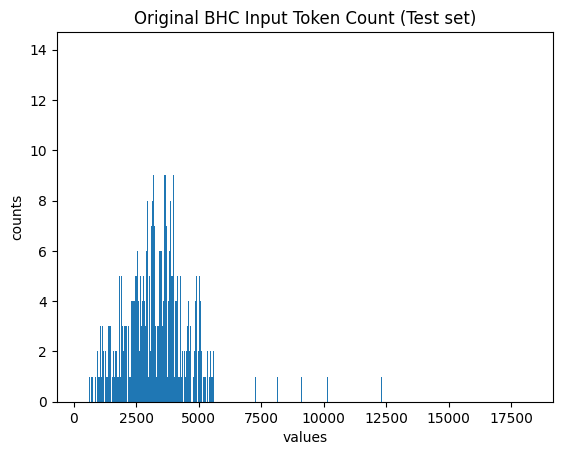

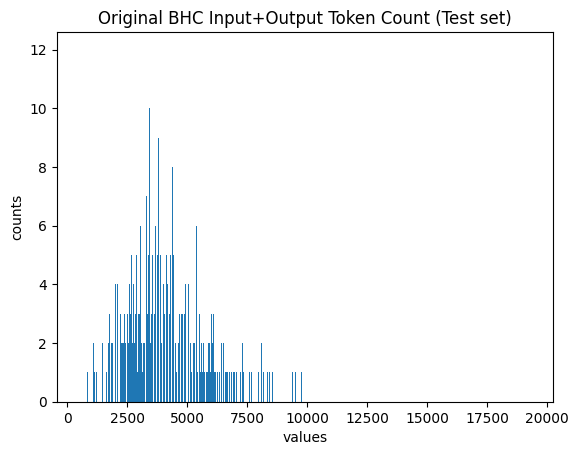

In [39]:
test_combined_discharge['original_bhc_input'] = get_bhc_input(test_combined_discharge)
test_combined_discharge['orginal_bhc_input_token_count'] = test_combined_discharge['original_bhc_input'].progress_apply(get_token_count)
plot_token_count(test_combined_discharge['orginal_bhc_input_token_count'],
                'Original BHC Input Token Count (Test set)')
plot_token_count(test_combined_discharge['orginal_bhc_input_token_count'] + test_combined_discharge['bhc_token_count'] , 
                'Original BHC Input+Output Token Count (Test set)')

**Stage1: First cleaning by extraction (By Haotian)**
i.e. keep and organize relevent sections without looking to much in details

In [40]:
clean1_bhc_input = extract_clean_inputs(test_combined_discharge,
                        features_to_include=[
                                'sex',
                                'allergies',
                                'chief_complaint',
                                'major_surgical_procedures',
                                'history_of_present_illness',
                                'past_medical_history',
                                'social_history',
                                'family_history',
                                'physical_exam',
                                'pertinent_results',
                            ])

100%|██████████| 14702/14702 [00:50<00:00, 290.01it/s]


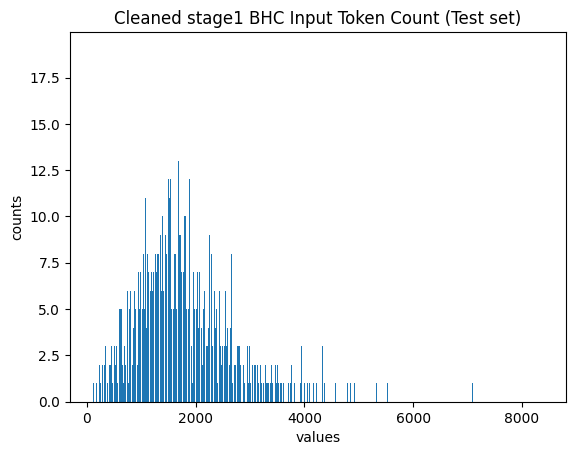

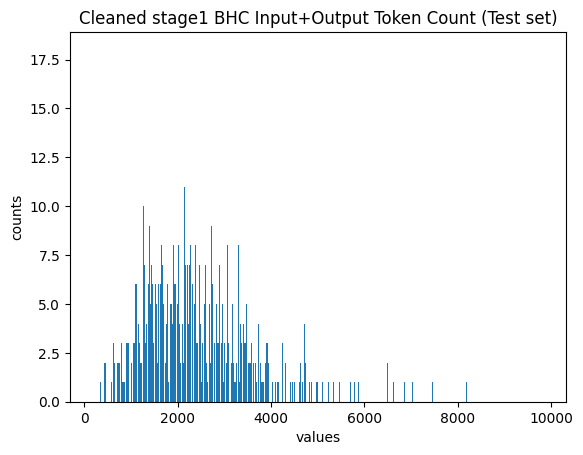

In [41]:
clean_1_bhc_input_token_count = clean1_bhc_input.progress_apply(get_token_count)
plot_token_count(clean_1_bhc_input_token_count,
                 'Cleaned stage1 BHC Input Token Count (Test set)')
plot_token_count(clean_1_bhc_input_token_count + test_combined_discharge['bhc_token_count'] ,
                 'Cleaned stage1 BHC Input+Output Token Count (Test set)')

**Stage2 :Removing some section**
- Remove `pertinent_results`, `major_surgical_procedures`, `physical_exam`
- Do not seem relevent for the task
- Lots of digits tokens etc. 

In [42]:
clean2_bhc_input = extract_clean_inputs(test_combined_discharge,
                            features_to_include=[
                                'sex',
                                'allergies',
                                'chief_complaint',
                                'major_surgical_procedures',
                                'history_of_present_illness',
                                'past_medical_history',
                                'social_history',
                                'family_history',
                                #'pertinent_results'
                                'physical_exam',
                            ])                                        


100%|██████████| 14702/14702 [00:36<00:00, 407.98it/s]


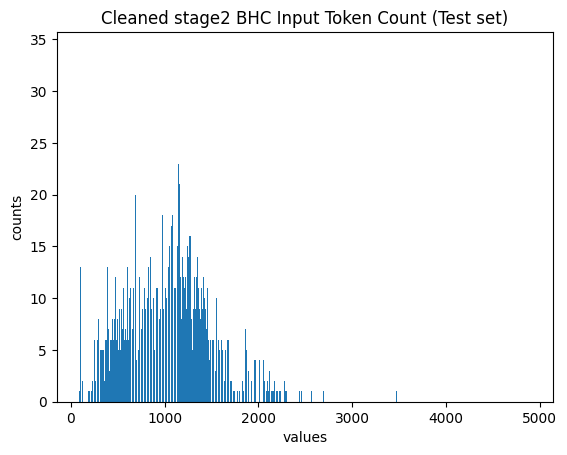

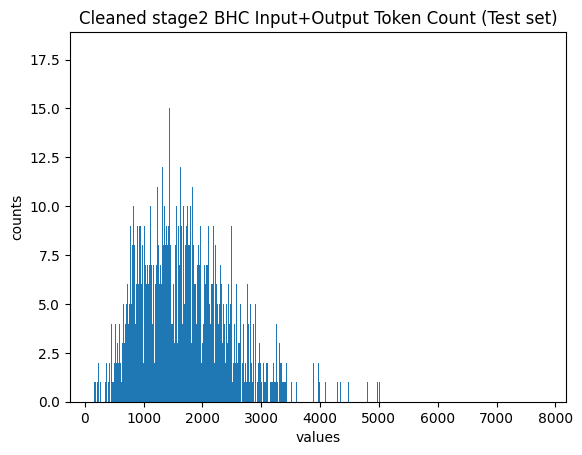

In [43]:
clean2_bhc_input_token_count = clean2_bhc_input.progress_apply(get_token_count)
plot_token_count(clean2_bhc_input_token_count,
                 'Cleaned stage2 BHC Input Token Count (Test set)')
plot_token_count(clean2_bhc_input_token_count + test_combined_discharge['bhc_token_count'] ,
                    'Cleaned stage2 BHC Input+Output Token Count (Test set)')


**Stage3 cleaning of specific token groups**
- Replacing 2 or more `__` by only one `_`
- Replacing at least 2 `======` by `\n`


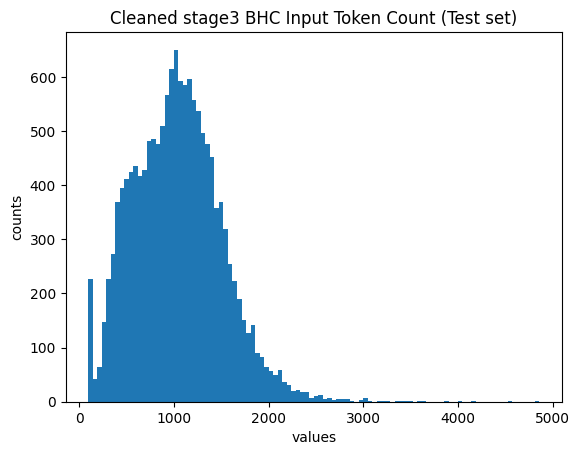

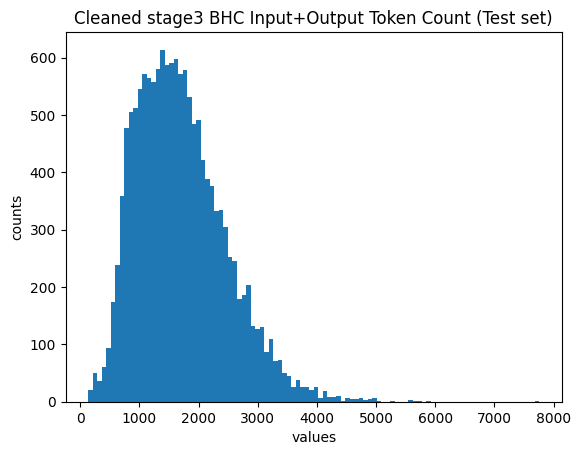

In [85]:
clean3_bhc_input= clean2_bhc_input.progress_apply(remove_underscores).progress_apply(treat_equals) 

clean3_bhc_input_token_count = clean3_bhc_input.progress_apply(get_token_count)
plot_token_count(clean3_bhc_input_token_count,
                 'Cleaned stage3 BHC Input Token Count (Test set)')
plot_token_count(clean3_bhc_input_token_count + test_combined_discharge['bhc_token_count'] ,
                    'Cleaned stage3 BHC Input+Output Token Count (Test set)')


In [90]:
indexes = clean3_bhc_input_token_count[clean3_bhc_input_token_count + test_combined_discharge['bhc_token_count']  > 3750].index

print('Number of samples with more than 3750 tokens:', len(indexes))
#print a few random ones

for i in indexes[:5]:
    print('Index:', i)
    print(clean3_bhc_input.loc[i])
    print('Token count:', clean3_bhc_input_token_count.loc[i])
    print('Token count + BHC:', clean3_bhc_input_token_count.loc[i] + test_combined_discharge.loc[i, 'bhc_token_count'])
    print('-------------------------')


Number of samples with more than 3750 tokens: 188
Index: 10
Sex: 
M
 
Allergies: 
Oxycodone / Ragweed
 
Chief Complaint: 
confusion, rehab placement 

Major Surgical or Invasive Procedure: 
-lumbar puncture _

History of Present Illness: 
_ male w/ PMH of sarcoidosis, sleep apnea, new-onset 
dementia of unknown etiolgy, hx of ITP s/p splenectomy presents 
to ED after falling at home in the setting of confusion and 
recent diagnosis of dementia. Per patient, he was in the bathtub 
taking a shower, when he began to feel nauseous and spit 
up/vomited, felt dizzy, slipped, and fell in the tub. Denies any 
chest pain, sob, headache, palpitations. Wife found him in the 
tub. Per wife, did not appear like he lost consciousness, no 
urine/stool incontinence, no confusion at the time. He was 
shivering/rigoring and she took him to the bed with help of _ 
to cover him with his electrical warming blanket. Patient 
insisted to going to the bathroom, but appeared more confused, 
urinating on the fl